In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression


def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


Ресемплинг данных

In [2]:
db = 'DUQ_hourly.csv'
data = pd.read_csv(db)
data["Datetime"] = pd.to_datetime(data["Datetime"])
data

,Datetime,DUQ_MW
0,2005-12-31 01:00:00,1458.0
1,2005-12-31 02:00:00,1377.0
2,2005-12-31 03:00:00,1351.0
3,2005-12-31 04:00:00,1336.0
4,2005-12-31 05:00:00,1356.0
...,...,...
119063,2018-01-01 20:00:00,1962.0
119064,2018-01-01 21:00:00,1940.0
119065,2018-01-01 22:00:00,1891.0
119066,2018-01-01 23:00:00,1820.0


In [3]:
data['date'] = data["Datetime"].apply( lambda data : 
datetime.datetime(year=data.year, month=data.month, day=data.day))
data.set_index(data["date"],inplace=True)
data

,Datetime,DUQ_MW,date
date,,,
2005-12-31,2005-12-31 01:00:00,1458.0,2005-12-31
2005-12-31,2005-12-31 02:00:00,1377.0,2005-12-31
2005-12-31,2005-12-31 03:00:00,1351.0,2005-12-31
2005-12-31,2005-12-31 04:00:00,1336.0,2005-12-31
2005-12-31,2005-12-31 05:00:00,1356.0,2005-12-31
...,...,...,...
2018-01-01,2018-01-01 20:00:00,1962.0,2018-01-01
2018-01-01,2018-01-01 21:00:00,1940.0,2018-01-01
2018-01-01,2018-01-01 22:00:00,1891.0,2018-01-01


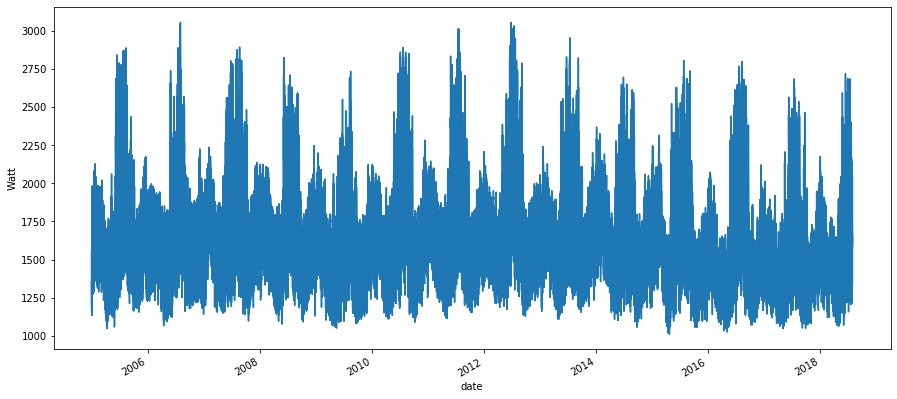

In [4]:
plt.figure(figsize(15,7))
data['DUQ_MW'].plot()
plt.ylabel('Watt')
pylab.show()

In [5]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [6]:
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

,Datetime,DUQ_MW,date,weekday,is_weekend
date,,,,,
2005-12-31,2005-12-31 01:00:00,1458.0,2005-12-31,5,1
2005-12-31,2005-12-31 02:00:00,1377.0,2005-12-31,5,1
2005-12-31,2005-12-31 03:00:00,1351.0,2005-12-31,5,1
2005-12-31,2005-12-31 04:00:00,1336.0,2005-12-31,5,1
2005-12-31,2005-12-31 05:00:00,1356.0,2005-12-31,5,1


In [7]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

#     data.index = data.index.to_datetime()
#     data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1

    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
#     data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

    # выкидываем закодированные средними признаки 
#     data.drop(["hour", "weekday"], axis=1, inplace=True)
    data.drop(["weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

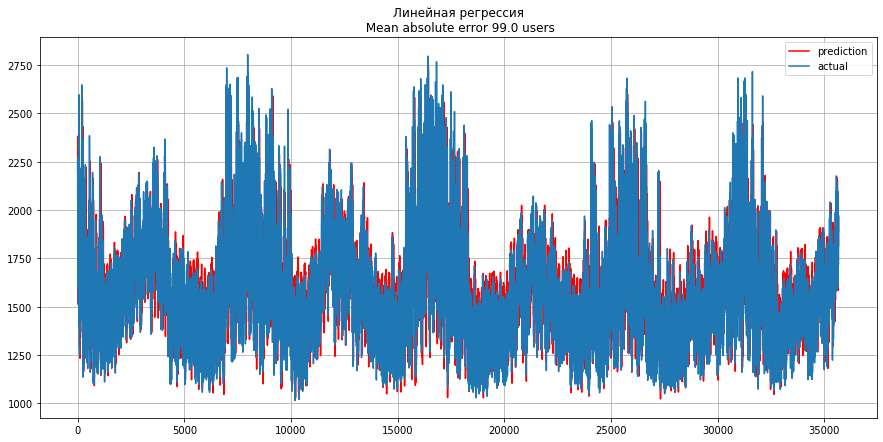

In [8]:
X_train, X_test, y_train, y_test = prepareData(data['DUQ_MW'], test_size=0.3, lag_start=12, lag_end=48)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Линейная регрессия\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

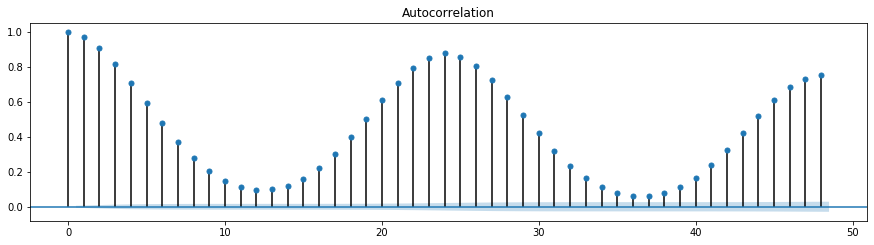

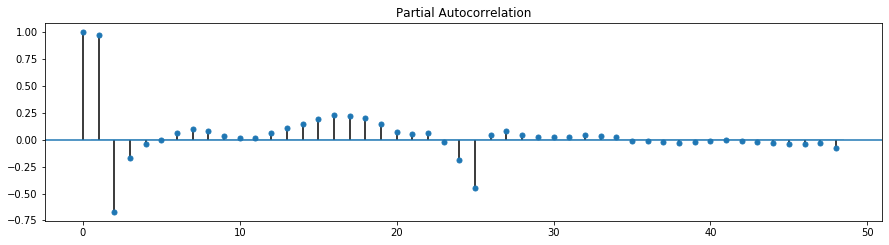

In [9]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['DUQ_MW'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['DUQ_MW'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()